In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')
nvmlShutdown()

GPU0 Memory: 10750MB


# 引用及参数

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

char_dir = 'G:\\my_code\\python\\MTWI2018\\char_std_6885.txt'
characters=''
char_to_id = {}
id_to_char = {}
with open(char_dir,encoding='utf-8') as f:
      for ch in f.readlines():
            ch = ch.strip('\r\n')
            characters=characters+ch
#characters =characters+'^'
print('nclass:',len(characters))
    
char_to_id = {j:i for i,j in enumerate(characters)}
id_to_char = {i:j for i,j in enumerate(characters)}
id_to_char[-1]=''
    
width, height, n_len, n_class = 200, 32, 50, len(characters) + 1
print(n_class)    

nclass: 6885
6886


In [3]:
print(id_to_char)

{0: ' ', 1: '，', 2: '的', 3: '。', 4: '一', 5: '是', 6: '0', 7: '不', 8: '在', 9: '有', 10: '、', 11: '人', 12: '“', 13: '”', 14: '了', 15: '中', 16: '国', 17: '大', 18: '为', 19: '1', 20: ':', 21: '上', 22: '2', 23: '这', 24: '个', 25: '以', 26: '年', 27: '生', 28: '和', 29: '我', 30: '时', 31: '之', 32: '也', 33: '来', 34: '到', 35: '要', 36: '会', 37: '学', 38: '对', 39: '业', 40: '出', 41: '行', 42: '公', 43: '能', 44: '他', 45: '于', 46: '5', 47: 'e', 48: '3', 49: '而', 50: '发', 51: '地', 52: '可', 53: '作', 54: '就', 55: '自', 56: '们', 57: '后', 58: '成', 59: '家', 60: '日', 61: '者', 62: '分', 63: '多', 64: '下', 65: '其', 66: '用', 67: '方', 68: '本', 69: '得', 70: '子', 71: '.', 72: '高', 73: '4', 74: '过', 75: '经', 76: '6', 77: '现', 78: '说', 79: '与', 80: '前', 81: 'o', 82: '理', 83: '工', 84: '所', 85: '力', 86: 't', 87: '如', 88: '将', 89: '军', 90: '部', 91: ',', 92: '事', 93: '进', 94: '9', 95: '司', 96: '场', 97: '同', 98: '机', 99: '主', 100: '都', 101: '实', 102: '天', 103: '面', 104: '市', 105: '8', 106: 'i', 107: 'a', 108: '新', 109: '动', 110: '开',

# 定义 CTC Loss

In [4]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    #y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 定义网络结构

In [5]:
from keras.layers import *
from keras.models import *
from make_parallel import make_parallel
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(1):
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32*2**i, (3, 3), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
print(conv_shape)
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
conv_shape1 = x.get_shape()
print('')
print('conv_shape1')
print(conv_shape1)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
conv_shape2 = x.get_shape()
print('')
print('conv_shape2')
print(conv_shape2)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

#base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')
#loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([base_model.output, labels, input_length, label_length])
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model.output, labels, input_length, label_length])

model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

(?, 98, 14, 32)

conv_shape1
(?, 98, 448)

conv_shape2
(?, 98, 128)


d:\ProgramData\Anaconda3\envs\captcha_demo\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


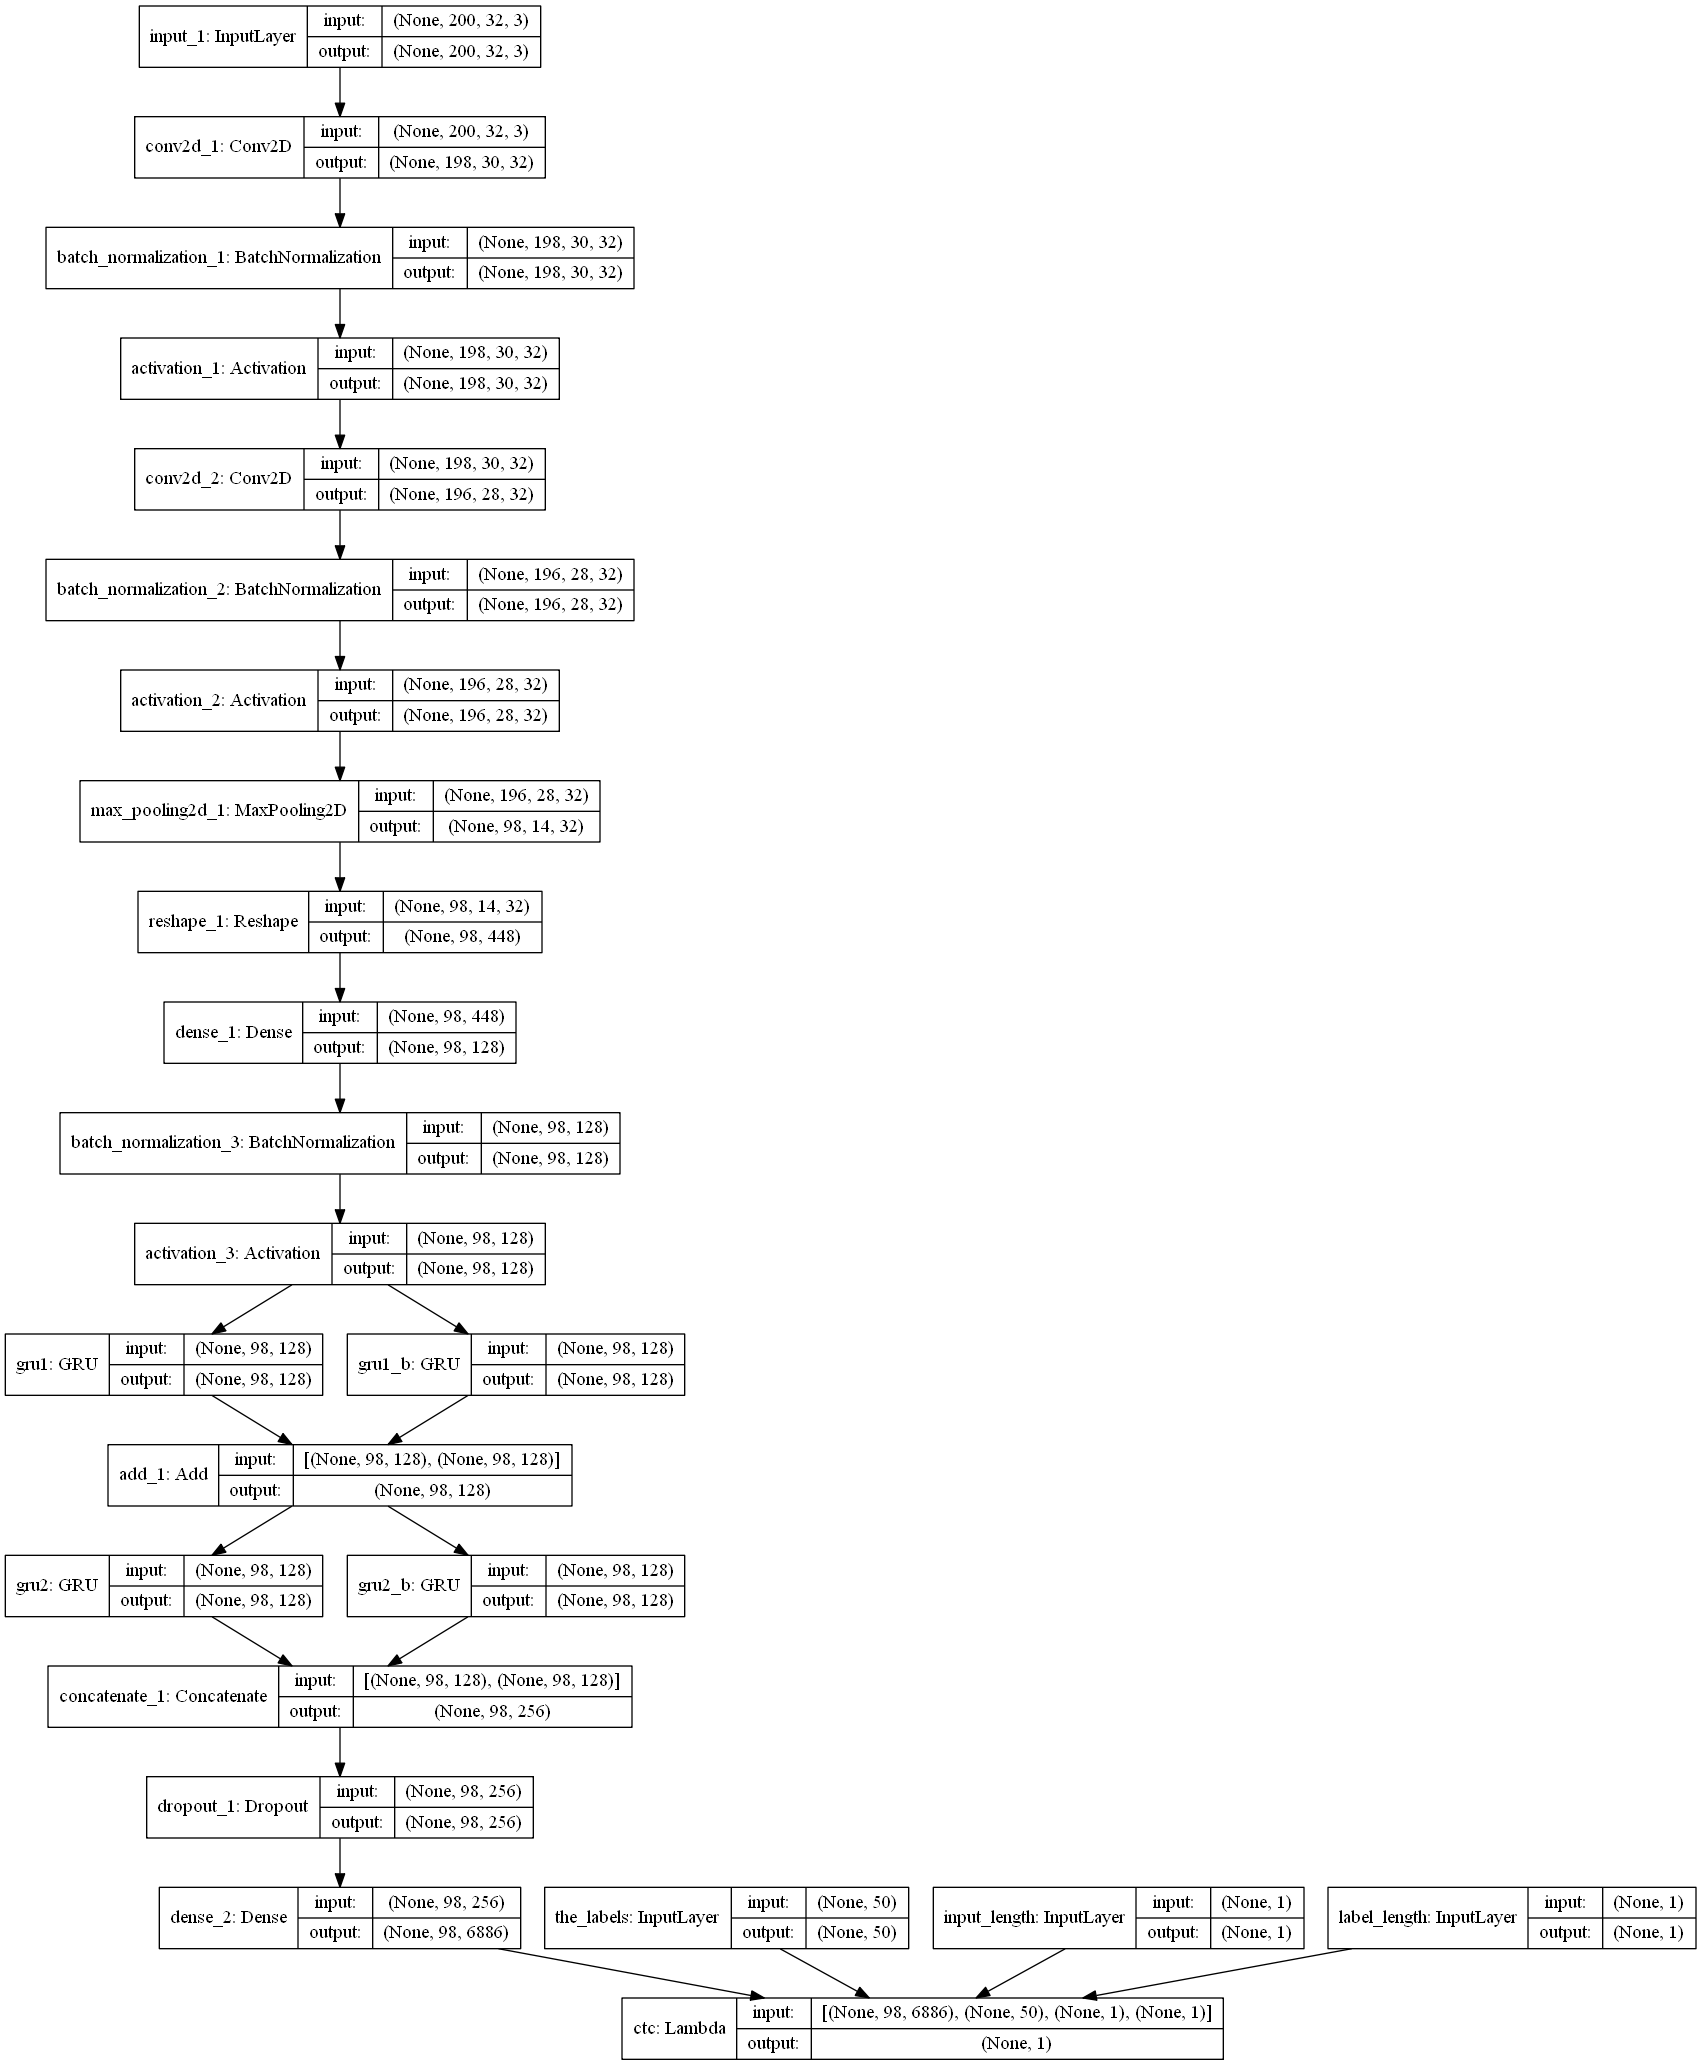

In [6]:
#from keras.utils.visualize_util import plot
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

#plot(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 定义数据生成器

In [7]:
def readfile(filename):
    res = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for i in lines:
            res.append(i.strip())
    dic = {}
    for i in res:
        p = i.split(' ')
        dic[p[0]] = p[1:]
    return dic

In [8]:
# #train_data_200_test.txt
# ab = readfile('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v20190616\\train_data_200_test.txt')
# #print(ab)
# #print(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg'])
# #print(len(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']))
# yyy = np.zeros((1, 200), dtype=np.int32)
# y[0,:len(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg'])] = [int(x) for x in train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']]
# # print([int(x) for x in train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']])
# yyy[0,len(train_image_label['TB1M2xKLXXXXXc2XpXXunYpLFXX_21.jpg']):] = -1
# print(yyy)

In [ ]:
train_label_path = 'G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v20190616\\train_data_200.txt'
train_image_label = readfile(train_label_path)#image_label[图像名] = char id
_imagefile_train = [i for i, j in train_image_label.items()]#图像名list
count = 0
def gen(train_image_label, _imagefile_train, batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.int32)
    label_length = np.ones(batch_size)
    global count
    while True:
        for i in range(batch_size):
            index = batch_size*count + i
            if index >= len(_imagefile_train):
                count = 0
                index = batch_size*count + i
            img_file_name = _imagefile_train[index]
            char_ids = train_image_label[img_file_name]
#             print('')
#             print(img_file_name)
            img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%img_file_name)
            X[i] = np.array(img[:,:,::-1]).transpose(1, 0, 2)
            y[i,:len(char_ids)] = [int(x) for x in char_ids]
            y[i,len(char_ids):] = -1
            label_length[i] = len(char_ids)
        print('')
        print(count)
        count = count + 1
        #yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), label_length], np.ones(batch_size)
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]), label_length], np.ones(batch_size)

#[X_test, y_test, _, label_length_test], _  = next(gen(image_label, _imagefile, 1))
#plt.imshow(X_test[0].transpose(1, 0, 2))
#print(y_test)
#plt.title(''.join([id_to_char[x] for x in y_test[0]]))

In [ ]:
# for i in range(len(_imagefile_train)):
#     if _imagefile_train[i]=='T1qiJGXyXfXXXXXXXX_!!0-item_pic.jpg_2.jpg':
#         print(i)
#         break

In [ ]:
# bat_size=256
# X = np.zeros((bat_size, width, height, 3), dtype=np.uint8)
# y = np.zeros((bat_size, 50), dtype=np.int32)
# label_length = np.ones(bat_size)
# for i in range(bat_size):
#     index = bat_size*35 + i
#     img_file_name = _imagefile_train[index]
#     print(img_file_name)
#     char_ids = train_image_label[img_file_name]
#     print(char_ids)
# #     print('')
# #     print(img_file_name)
#     img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%img_file_name)
#     X[i] = np.array(img[:,:,::-1]).transpose(1, 0, 2)
#     y[i,:len(char_ids)] = [int(x) for x in char_ids]
#     y[i,len(char_ids):] = -1
#     print(i)
#     label_length[i] = len(char_ids)

In [ ]:
# print(y[8,:])
# print(label_length[8])
# print(''.join([id_to_char[x] for x in y[8,:]]))

# 验证函数和回调函数

In [ ]:
from tqdm import tqdm
import pandas as pd
import cv2
test_label_path = 'G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v20190616\\test_data.txt'
test_image_label = readfile(test_label_path)#image_label[图像名] = char id
_imagefile_test = [i for i, j in test_image_label.items()]#图像名list
#df = pd.read_csv('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\txt_train_out_v1\\data.txt', sep=' ', header=None)
n_test = 19570
X_test = np.zeros((n_test, width, height, 3), dtype=np.uint8)
y_test = np.zeros((n_test, n_len), dtype=np.int32)
label_length_test = np.zeros((n_test, 1), dtype=np.int32)

for i,item in tqdm(enumerate(_imagefile_test)):
    img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%item)
    X_test[i] = img[:,:,::-1].transpose(1, 0, 2)#将图像逆时针旋转90度后，上下翻转
    random_str = test_image_label[item]
    y_test[i,:len(random_str)] = [int(x) for x in random_str]
    y_test[i,len(random_str):] = -1
    label_length_test[i] = len(random_str)

19570it [00:04, 4444.47it/s]


In [ ]:
# def evaluate(model):
#     y_pred = base_model.predict(X_test, batch_size=16)
#     shape = y_pred[:,2:,:].shape
#     out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :n_len]
#     if out.shape[1] > 4:
#         return (y_test == out).all(axis=-1).mean()
#     return 0

In [ ]:
# from keras.callbacks import *

# class Evaluate(Callback):
#     def __init__(self):
#         self.accs = []
    
#     def on_epoch_end(self, epoch, logs=None):
#         acc = evaluate(base_model)*100
#         self.accs.append(acc)
#         print
#         print('val_acc: %f%%'%acc)

# evaluator = Evaluate()

# 训练

In [ ]:
from keras.optimizers import *
from keras.callbacks import *

batch_size = 128
#compile的时候，直接将loss设置为y_pred（因为模型的输出就是loss，所以y_pred就是loss），
#无视y_true，训练的时候，y_true随便扔一个符合形状的数组进去就行了
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3))#lr先设成Adam(1e-3)快速试错，看能否收敛#optimizer=Adam(1e-4))
h = model.fit_generator(gen(train_image_label, _imagefile_train,batch_size), 
                        #pickle_safe=True, workers=12, 
                        #workers=1,
                        use_multiprocessing=False,
                        #validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]-2), label_length_test], np.ones(n_test)), 
                        validation_data=([X_test, y_test, np.ones(n_test)*int(conv_shape[1]), label_length_test], np.ones(n_test)), 
                        steps_per_epoch=78276/batch_size, epochs=1, #调试只设1代，正常50到150
                        callbacks=[ReduceLROnPlateau('loss'), ModelCheckpoint('model_gru_best.h5', save_best_only=True)]
                       )

Epoch 1/1

0

1

2

3

4

5

6

7

8

9

10
  1/611 [..............................] - ETA: 41:42 - loss: 814.8882
11
  2/611 [..............................] - ETA: 27:29 - loss: 764.7144
12
  3/611 [..............................] - ETA: 22:38 - loss: 706.1914
13
  4/611 [..............................] - ETA: 20:12 - loss: 643.4705
14
  5/611 [..............................] - ETA: 18:46 - loss: 579.2496
15
  6/611 [..............................] - ETA: 17:50 - loss: 513.7946
16
  7/611 [..............................] - ETA: 17:07 - loss: 454.6843
17
  8/611 [..............................] - ETA: 16:39 - loss: 404.8456
18
  9/611 [..............................] - ETA: 16:14 - loss: 364.0500
19
 10/611 [..............................] - ETA: 15:52 - loss: 331.1610
20
 11/611 [..............................] - ETA: 15:34 - loss: 303.9907
21
 12/611 [..............................] - ETA: 15:22 - loss: 281.5524
22
 13/611 [..............................] - ETA: 15:08 - loss: 262.40

In [ ]:
model.save('model.h5')

In [ ]:
# test_img = cv2.imread('G:\\my_code\\python\\MTWI2018\\mtwi_2018_train\\image_train_out_v20190616\\%s'%img_file_name)
# np_test_img = np.array(test_img[:,:,::-1]).transpose(1, 0, 2)
# y_pred = base_model.predict(np_test_img)
# test_shape = y_pred[:,2:,:].shape
# out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(test_shape[0])*test_shape[1])[0][0])[:, :n_len]
# s = ''.join([id_to_char[x] for x in out[i] if x > -1])